# Baseline + Dataset Comparison (LHS vs QBC)

This notebook compares:

- baseline metrics (`mse`, `rmse`) across runs
- IC-space distributions for two datasets
- PCA projection of ICs
- optional QBC round history

It is configured for your current setup (`dataset_v1` and `dataset_v2`).

In [1]:
from __future__ import annotations

import json
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

plt.style.use('default')
pd.set_option('display.max_columns', 200)

In [2]:
def find_project_root(start: Path | None = None) -> Path:
    start = Path.cwd() if start is None else start
    for p in [start, *start.parents]:
        if (p / 'create_dataset.py').exists() and (p / 'src').exists():
            return p
    raise RuntimeError('Project root not found. Run notebook inside repository.')


PROJECT_ROOT = find_project_root()
OUTPUTS_DIR = PROJECT_ROOT / 'outputs'
DATA_DIR = PROJECT_ROOT / 'data'

print('PROJECT_ROOT =', PROJECT_ROOT)
print('OUTPUTS_DIR  =', OUTPUTS_DIR)
print('DATA_DIR     =', DATA_DIR)

PROJECT_ROOT = /Users/jonaswiendl/local/Repos/ml-surrogates-for-power-systems
OUTPUTS_DIR  = /Users/jonaswiendl/local/Repos/ml-surrogates-for-power-systems/outputs
DATA_DIR     = /Users/jonaswiendl/local/Repos/ml-surrogates-for-power-systems/data


## Configuration

In [3]:
# Map names to dataset versions
DATASET_MAP = {
    'qbc': 1,
    'lhs': 2,
}

# Metrics search paths (add more patterns if needed)
METRICS_GLOBS = [
    'baseline/**/metrics.json',
]

# Raw IC sampling for visualization
MAX_IC_SAMPLES_PER_DATASET = 5000  # keep plotting responsive
RANDOM_SEED = 37

# Dynamic IC dimension labels used in plots (exclude static E_d_dash)
IC_DIM_NAMES = ['theta', 'omega', 'E_q_dash']


## Helpers

In [4]:
def load_json(path: Path):
    with path.open('r', encoding='utf-8') as f:
        return json.load(f)


def collect_baseline_metrics(outputs_dir: Path) -> pd.DataFrame:
    rows = []
    seen = set()
    for pat in METRICS_GLOBS:
        for path in outputs_dir.glob(pat):
            if path in seen:
                continue
            seen.add(path)
            try:
                m = load_json(path)
            except Exception:
                continue
            if 'dataset_number' not in m or 'rmse' not in m:
                continue
            rows.append({
                'path': str(path),
                'dataset_number': int(m['dataset_number']),
                'n_train': int(m.get('n_train', -1)),
                'n_test': int(m.get('n_test', -1)),
                'mse': float(m['mse']),
                'rmse': float(m['rmse']),
            })
    if not rows:
        return pd.DataFrame(columns=['path', 'dataset_number', 'n_train', 'n_test', 'mse', 'rmse'])
    df = pd.DataFrame(rows).sort_values(['dataset_number', 'rmse']).reset_index(drop=True)
    return df


def read_raw_ics(data_dir: Path, model_flag: str, dataset_number: int, max_samples: int | None = None, seed: int = 0) -> np.ndarray:
    raw_dir = data_dir / model_flag / f'dataset_v{dataset_number}' / 'raw'
    if not raw_dir.exists():
        raise FileNotFoundError(f'Raw dir not found: {raw_dir}')
    ics = []
    for pkl_path in sorted(raw_dir.glob('file*.pkl')):
        with pkl_path.open('rb') as f:
            payload = pickle.load(f)
        for traj in payload:
            arr = np.asarray(traj, dtype=np.float32)
            ics.append(arr[1:, 0])  # ICs are channels at t=0
    if not ics:
        raise ValueError(f'No trajectories found in {raw_dir}')
    x = np.stack(ics, axis=0)
    if max_samples is not None and x.shape[0] > max_samples:
        rng = np.random.default_rng(seed)
        idx = rng.choice(x.shape[0], size=max_samples, replace=False)
        x = x[idx]
    return x


def pca_2d(x: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    x = np.asarray(x, dtype=np.float64)
    mu = x.mean(axis=0, keepdims=True)
    sd = x.std(axis=0, keepdims=True)
    sd[sd < 1e-12] = 1.0
    z = (x - mu) / sd
    # SVD-based PCA
    _, s, vt = np.linalg.svd(z, full_matrices=False)
    comps = vt[:2].T
    proj = z @ comps
    var = (s**2) / (z.shape[0] - 1)
    var_ratio = var / var.sum()
    return proj, var_ratio[:2]


def load_qbc_history(outputs_dir: Path, run_name: str = 'large_sm4') -> pd.DataFrame:
    hist_path = outputs_dir / 'qbc' / run_name / 'history.jsonl'
    if not hist_path.exists():
        return pd.DataFrame()
    rows = []
    with hist_path.open('r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    if not rows:
        return pd.DataFrame()
    return pd.DataFrame(rows).sort_values('round_idx').reset_index(drop=True)

## Baseline metrics comparison

In [5]:
metrics_df = collect_baseline_metrics(OUTPUTS_DIR)
display(metrics_df)

if not metrics_df.empty:
    name_by_num = {v: k for k, v in DATASET_MAP.items()}
    metrics_df['dataset_name'] = metrics_df['dataset_number'].map(name_by_num).fillna(metrics_df['dataset_number'].astype(str))
    summary = metrics_df.groupby(['dataset_number', 'dataset_name'], as_index=False).agg(
        runs=('rmse', 'count'),
        rmse_mean=('rmse', 'mean'),
        rmse_std=('rmse', 'std'),
        mse_mean=('mse', 'mean'),
        mse_std=('mse', 'std'),
    )
    display(summary)
else:
    print('No baseline metrics found in outputs.')

,path,dataset_number,n_train,n_test,mse,rmse
0,/Users/jonaswiendl/local/Repos/ml-surrogates-f...,1,1728,480,0.000137,0.011714
1,/Users/jonaswiendl/local/Repos/ml-surrogates-f...,1,1728,480,0.000144,0.011999
2,/Users/jonaswiendl/local/Repos/ml-surrogates-f...,1,1728,480,0.000260,0.016139
3,/Users/jonaswiendl/local/Repos/ml-surrogates-f...,2,1728,480,0.000168,0.012970
4,/Users/jonaswiendl/local/Repos/ml-surrogates-f...,2,1728,480,0.000183,0.013516
5,/Users/jonaswiendl/local/Repos/ml-surrogates-f...,2,1728,480,0.000518,0.022761


,dataset_number,dataset_name,runs,rmse_mean,rmse_std,mse_mean,mse_std
0,1,qbc,3,0.013284,0.002477,0.000181,0.000069
1,2,lhs,3,0.016415,0.005502,0.000290,0.000198


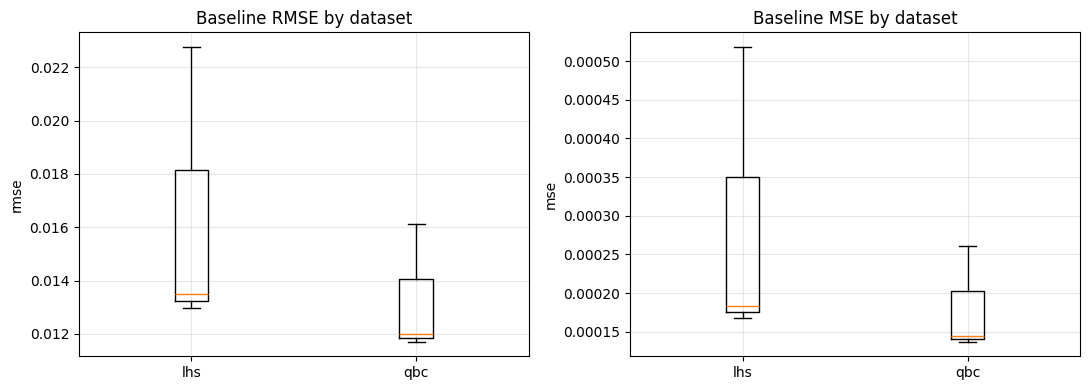

In [6]:
if not metrics_df.empty:
    plot_df = metrics_df.copy()
    name_by_num = {v: k for k, v in DATASET_MAP.items()}
    plot_df['dataset_name'] = plot_df['dataset_number'].map(name_by_num).fillna(plot_df['dataset_number'].astype(str))

    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    for i, metric in enumerate(['rmse', 'mse']):
        groups = [g[metric].values for _, g in plot_df.groupby('dataset_name')]
        labels = [k for k, _ in plot_df.groupby('dataset_name')]
        axes[i].boxplot(groups, tick_labels=labels)
        axes[i].set_title(f'Baseline {metric.upper()} by dataset')
        axes[i].set_ylabel(metric)
        axes[i].grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

## IC-space comparison (raw trajectories)

In [7]:
ics_by_name = {}
for name, num in DATASET_MAP.items():
    x = read_raw_ics(DATA_DIR, 'SM4', num, max_samples=MAX_IC_SAMPLES_PER_DATASET, seed=RANDOM_SEED)
    ics_by_name[name] = x
    print(f'{name}: {x.shape[0]} samples, IC dim={x.shape[1]}')

qbc: 2400 samples, IC dim=6
lhs: 2400 samples, IC dim=6


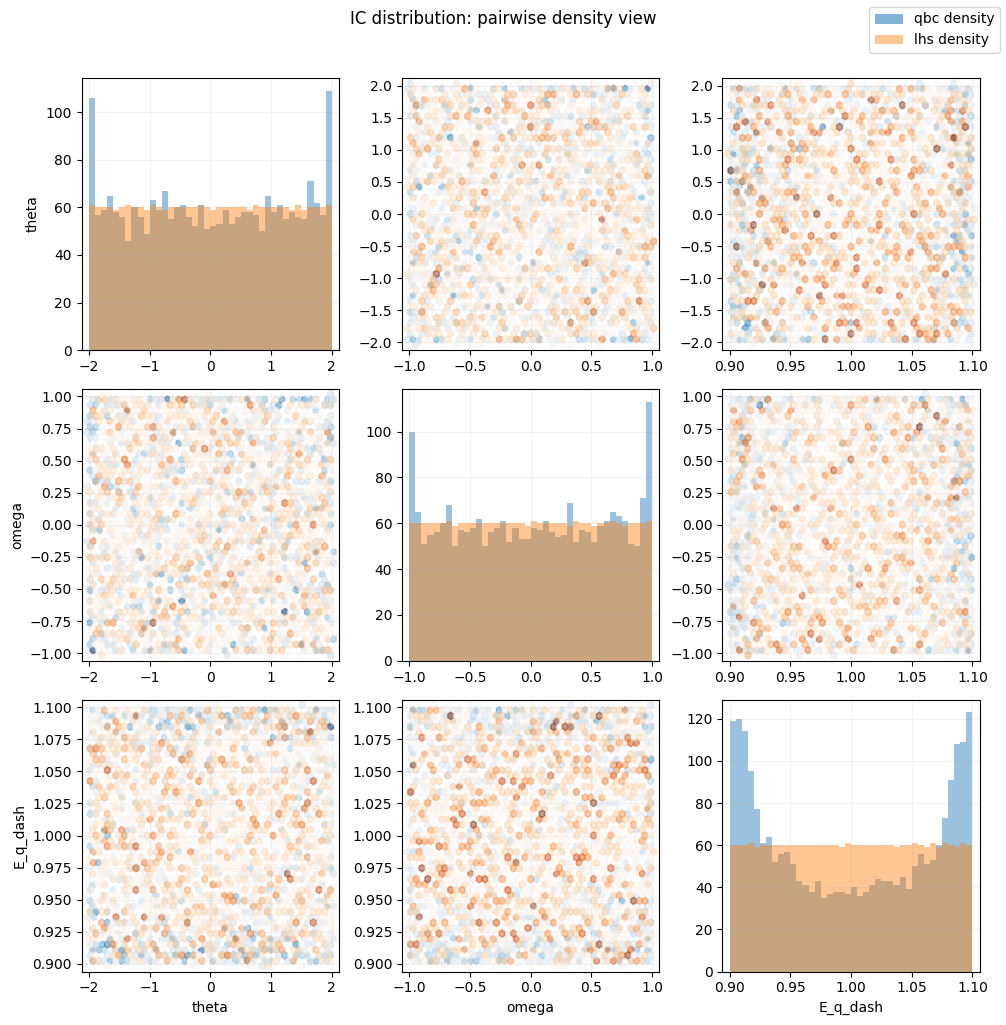

In [13]:
# Pairwise density view for selected dynamic dimensions
dims = [0, 1, 3]  # drop static E_d_dash (index 2)
names = IC_DIM_NAMES if len(IC_DIM_NAMES) >= len(dims) else [f'ic{i}' for i in dims]
fig, axes = plt.subplots(len(dims), len(dims), figsize=(10, 10))
# dataset handles (expecting qbc/lhs names from DATASET_MAP)
x_qbc = ics_by_name.get('qbc')
x_lhs = ics_by_name.get('lhs')
if x_qbc is None or x_lhs is None:
    raise ValueError("Expected dataset names 'qbc' and 'lhs' in ics_by_name for density plotting.")
# Precompute limits
limits = {}
for d in dims:
    vals = np.concatenate([x[:, d] for x in ics_by_name.values()])
    pad = 0.03 * (vals.max() - vals.min() + 1e-12)
    limits[d] = (vals.min() - pad, vals.max() + pad)
for r, dr in enumerate(dims):
    for c, dc in enumerate(dims):
        ax = axes[r, c]
        if r == c:
            ax.hist(x_qbc[:, dr], bins=40, alpha=0.45, label='qbc', color='tab:blue')
            ax.hist(x_lhs[:, dr], bins=40, alpha=0.45, label='lhs', color='tab:orange')
            ax.set_xlim(*limits[dr])
        else:
            ax.hexbin(
                x_qbc[:, dc], x_qbc[:, dr],
                gridsize=45, mincnt=1, cmap='Blues', alpha=0.55,
                extent=(limits[dc][0], limits[dc][1], limits[dr][0], limits[dr][1])
            )
            ax.hexbin(
                x_lhs[:, dc], x_lhs[:, dr],
                gridsize=45, mincnt=1, cmap='Oranges', alpha=0.45,
                extent=(limits[dc][0], limits[dc][1], limits[dr][0], limits[dr][1])
            )
            ax.set_xlim(*limits[dc])
            ax.set_ylim(*limits[dr])
        if r == len(dims) - 1:
            ax.set_xlabel(names[c])
        if c == 0:
            ax.set_ylabel(names[r])
        ax.grid(alpha=0.15)
# Legend proxies for density layers
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor='tab:blue', alpha=0.55, label='qbc density'),
    Patch(facecolor='tab:orange', alpha=0.45, label='lhs density'),
]
fig.legend(handles=legend_handles, loc='upper right')
fig.suptitle('IC distribution: pairwise density view', y=1.02)
fig.tight_layout()
plt.show()


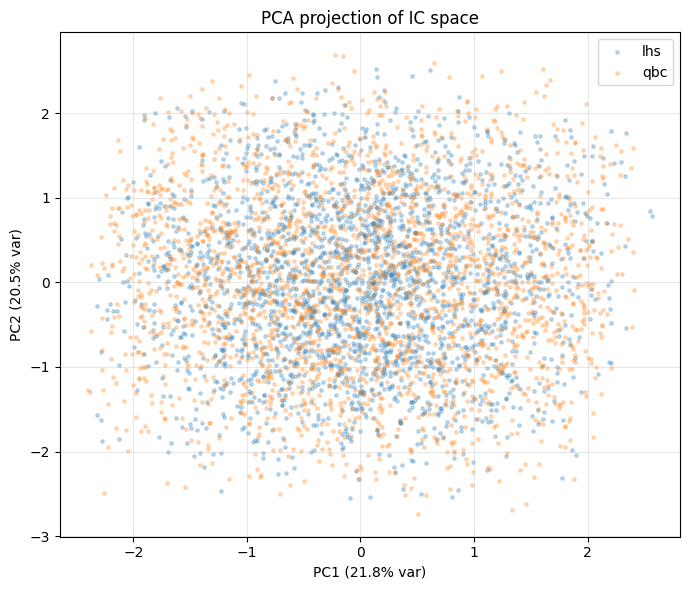

In [14]:
# PCA 2D projection
all_x = []
all_lab = []
for name, x in ics_by_name.items():
    all_x.append(x)
    all_lab.extend([name] * x.shape[0])
all_x = np.vstack(all_x)
all_lab = np.array(all_lab)

proj, var_ratio = pca_2d(all_x)

fig, ax = plt.subplots(figsize=(7, 6))
for name in sorted(set(all_lab)):
    m = all_lab == name
    ax.scatter(proj[m, 0], proj[m, 1], s=6, alpha=0.25, label=name)
ax.set_xlabel(f'PC1 ({var_ratio[0]*100:.1f}% var)')
ax.set_ylabel(f'PC2 ({var_ratio[1]*100:.1f}% var)')
ax.set_title('PCA projection of IC space')
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

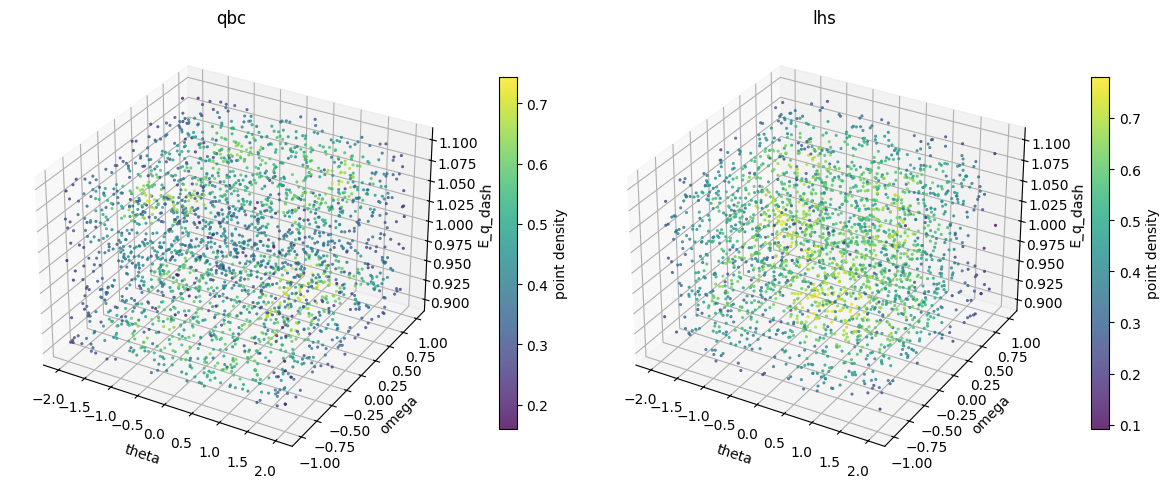

In [17]:
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure(figsize=(12, 5))

for i, (name, x) in enumerate(ics_by_name.items(), start=1):
    ax = fig.add_subplot(1, len(ics_by_name), i, projection='3d')

    pts = np.vstack([x[:, 0], x[:, 1], x[:, 3]])  # theta, omega, E_q_dash
    dens = gaussian_kde(pts)(pts)                 # local density per point

    # plot low-density first, high-density last for better visibility
    order = np.argsort(dens)
    xs, ys, zs, ds = x[order, 0], x[order, 1], x[order, 3], dens[order]

    sc = ax.scatter(
        xs, ys, zs,
        c=ds,
        cmap='viridis',
        s=5,
        alpha=0.8,
        linewidth=0
    )

    ax.set_title(name)
    ax.set_xlabel(names[0])
    ax.set_ylabel(names[1])
    ax.set_zlabel(names[2])

    cbar = fig.colorbar(sc, ax=ax, pad=0.08, shrink=0.75)
    cbar.set_label("point density")

plt.tight_layout()
plt.show()


## QBC history (optional)

,round_idx,train_size,mean_disagreement,max_disagreement,eval_rmse
0,0,5000,0.000058,0.000112,0.005153
1,1,6000,0.000075,0.000149,0.005155
2,2,7000,0.000017,0.000048,0.006502
3,3,8000,0.000044,0.000093,0.007156
4,4,9000,0.000022,0.000073,0.003481


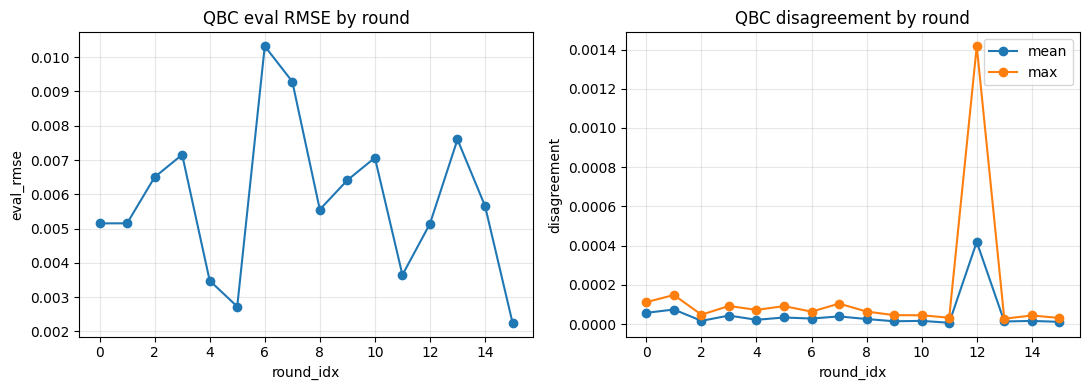

In [16]:
hist = load_qbc_history(OUTPUTS_DIR, run_name='large_sm4')
if hist.empty:
    print('No QBC history found at outputs/qbc/large_sm4/history.jsonl')
else:
    display(hist[['round_idx', 'train_size', 'mean_disagreement', 'max_disagreement', 'eval_rmse']].head())
    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    axes[0].plot(hist['round_idx'], hist['eval_rmse'], marker='o')
    axes[0].set_title('QBC eval RMSE by round')
    axes[0].set_xlabel('round_idx')
    axes[0].set_ylabel('eval_rmse')
    axes[0].grid(alpha=0.3)

    axes[1].plot(hist['round_idx'], hist['mean_disagreement'], marker='o', label='mean')
    axes[1].plot(hist['round_idx'], hist['max_disagreement'], marker='o', label='max')
    axes[1].set_title('QBC disagreement by round')
    axes[1].set_xlabel('round_idx')
    axes[1].set_ylabel('disagreement')
    axes[1].grid(alpha=0.3)
    axes[1].legend()
    plt.tight_layout()
    plt.show()